Detecção de valores anômalos
============================



## Importações



In [1]:
import numpy as np
import seaborn as sns
from sklearn import datasets
import matplotlib.pyplot as plt

## Introdução



Em um conjunto de dados, um exemplo que desvie significativamente do comportamento dos demais é chamado de *valor anômalo* ou *outlier*. Este tipo de valor pode gerar dúvidas sobre o seu processo de coleta. Este tipo de valor pode representar uma novidade ou peculiaridade. Além disso, o comportamento &ldquo;inconsistente&rdquo; deste valor com relação aos demais exemplos pode prejudicar a convergência e generalização de modelos de aprendizado de máquina induzidos usando este conjunto de dados.

Uma forma de visualizar o conceito de valores anômalos é apresentada abaixo (ideia reproduzida de uma imagem da Ref. [1]). Na sua intuição, quantos e quais são os valores anômalos no dataset de emojis abaixo?

🙉 🙊 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉

🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉

🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉

🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙈 🙉 🙉 🙉 🙉 🙉

🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉

🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉

🙉 🙉 🙈 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉

🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉 🙉

<code style="background:black;color:black">
Você deve ter percebido visualmente que existem três emojis diferentes acima. A maioria deles é o macaco tampando os ouvidos, mas existem dois macacos tampando os olhos e um macaco tampando a boca. Como pode ver, os macacos tampando os olhos e tampando a boca aparecem em tão pouca quantidade que se destacam dos demais. São valores anômalos deste conjunto de dados.
</code>

Este conjunto de dados dos macacos nos permite identificar os valores anômalos visualmente. Na maioria dos conjuntos de dados que trabalhamos não temos essa vantagem e precisamos de estratégias para nos ajudar a identificar estes valores.

<font color="red"> **Cuidado: valores anômalos não significam valores que devem ser descartados!**

É importante deixar claro que <u>valores anômalos não são sinônimo de &ldquo;valores que devem ser descartados&rdquo;</u>! Existem diversos valores anômalos de altíssimo interesse científico! O fenômeno da supercondutividade, por exemplo, foi inicialmente descartado por ter sido identificado como um valor anômalo e apenas revisitado anos depois.

Veremos abaixo algoritmos de identificação de valores anômalos. Estas estratégias nos convidam a explorar esses valores anômalos com cuidado em busca de pistas sobre o que levou eles a serem anômalos. Um valor anômalo pode ser apenas um erro de digitação, mas quem sabe pode ser a chave para o próximo grande avanço científico.



## Estratégias de detecção



Existem duas estratégias de detecção de valores anômalos:

1.  Quando se quer identificar valores anômalos *dentro* de um conjunto de dados já existente. Chamamos essa estratégia de <u>detecção de *outliers*</u> (ou, se preferir em português, detecção de valores atípicos ou de valores discrepantes).

2.  Quando se quer identificar valores anômalos em um ou mais dados *novos* em relação a um conjunto de dados já existente. Chamamos essa estratégia de <u>detecção de novidade</u>.

A estratégia de <u>detecção de outliers</u> foi o que fizemos no exemplo dos emojis de macacos acima. Tínhamos um conjunto de dados e gostaríamos de identificar valores anômalos *dentro* deste conjunto.

A estratégia de <u>detecção de novidade</u> é utilizada quando se quer identificar fraudes bancárias, por exemplo, pois são eventos *novos* com comportamento distinto das transações usuais.



## Gerando dados sintéticos



O código abaixo cria a lista `lista_dados` que contém 5 conjuntos de dados sintéticos para usarmos nas próximas seções. O código foi baseado no exemplo escrito por Alexandre Gramfort e Albert Thomas [2].

Primeiramente vamos definir as constantes.



In [2]:
SEMENTE_ALEATORIA = 61455
N_EXEMPLOS = 300
N_FEATURES = 2
FRACAO_OUTLIERS = 0.15

n_outliers = int(FRACAO_OUTLIERS * N_EXEMPLOS)
n_inliers = N_EXEMPLOS - n_outliers

Agora criamos os datasets sintéticos!



In [3]:
rng = np.random.RandomState(SEMENTE_ALEATORIA)

x_1 = datasets.make_blobs(
    centers=[[0, 0], [0, 0]],
    cluster_std=0.5,
    random_state=SEMENTE_ALEATORIA,
    n_samples=n_inliers,
    n_features=N_FEATURES,
)[0]

x_2 = datasets.make_blobs(
    centers=[[2, 2], [-2, -2]],
    cluster_std=[0.5, 0.5],
    random_state=SEMENTE_ALEATORIA,
    n_samples=n_inliers,
    n_features=N_FEATURES,
)[0]

x_3 = datasets.make_blobs(
    centers=[[2, 2], [-2, -2]],
    cluster_std=[1.5, 0.3],
    random_state=SEMENTE_ALEATORIA,
    n_samples=n_inliers,
    n_features=N_FEATURES,
)[0]

x_4 = datasets.make_moons(
        n_samples=N_EXEMPLOS,
        noise=0.05,
        random_state=SEMENTE_ALEATORIA,
)[0] * 4 - np.array([0.5, 0.25])

x_5 = 14.0 * (rng.rand(N_EXEMPLOS, N_FEATURES) - 0.5)

Por fim, adicionamos valores anômalos aos datasets criados.



In [4]:
lista_dados = []

for x in [x_1, x_2, x_3, x_4, x_5]:
    x_com_ruido = np.concatenate(
        [x, rng.uniform(low=-6, high=6, size=(n_outliers, N_FEATURES))], axis=0
    )

    lista_dados.append(x_com_ruido)

Vamos checar visualmente os dados que geramos. Observe que em geral conseguimos *visualmente* identificar onde estão os valores anômalos. Será que um algoritmo conseguiria também? Se os dados tivessem mais dimensões seria mais difícil de identificar visualmente&#x2026;



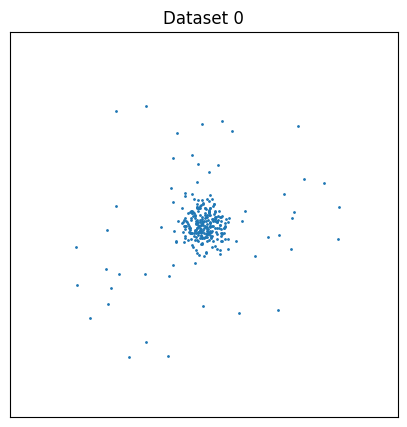

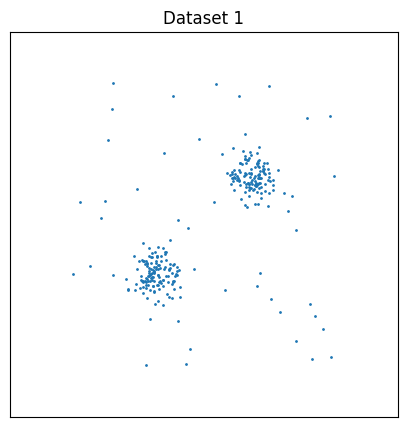

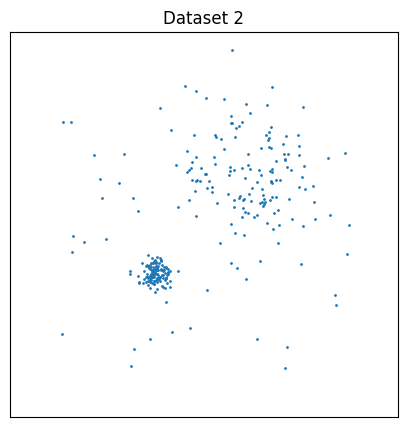

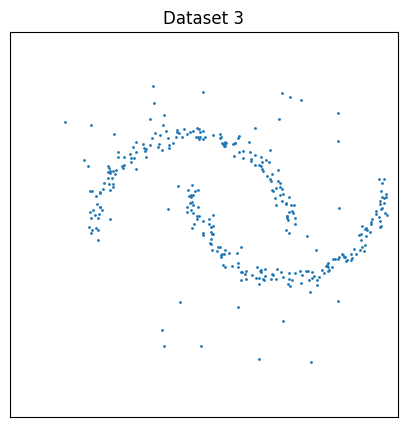

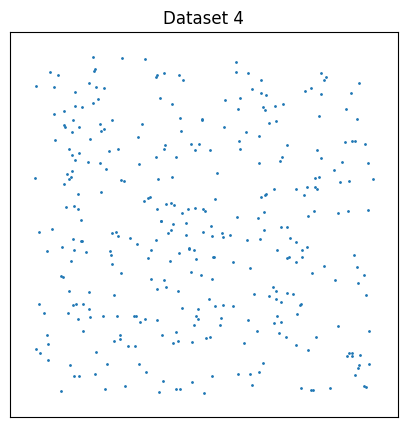

In [5]:
for n, dados in enumerate(lista_dados):
    figura, eixo = plt.subplots(figsize=(5, 5))

    eixo.scatter(
        dados[:, 0],
        dados[:, 1],
        marker=".",
        s=4,
    )

    eixo.set_xlim(-8, 8)
    eixo.set_ylim(-8, 8)
    eixo.set_xticks(())
    eixo.set_yticks(())
    eixo.set_title(f"Dataset {n}")

    plt.show()

## Algoritmo Fator de Outlier Local (LOF)



### O algoritmo



O Fator de Outlier Local (*Local Outlier Factor*, LOF) é um algoritmo de detecção de outliers que utiliza a distância entre os pontos para realizar a sua detecção.

Este algoritmo usa o conceito dos $k$ vizinhos mais próximos que vimos no algoritmo de aprendizado supervisionado $k$​-NN. Os passos para utilizar este algoritmo são:

1.  Determine quais são os dados onde quer identificar valores anômalos;

2.  Escolha o número $k$ de vizinhos a serem considerados;

3.  Compute o valor de LOF para todos os exemplos do conjunto de dados (ver próxima seção). Valores LOF significativamente maiores que 1 são dados que estão em regiões menos densas de pontos e têm maior chance de serem valores anômalos. Escolha um valor de limiar de LOF para rotular os valores anômalos.

Pode ser interessante assistir ao vídeo da Ref. [3] e ler a página da Wikipédia sobre este assunto [4].



### Cálculo do valor de LOF



Suponha que deseja calcular o valor de LOF para um exemplo $A$ qualquer.

Encontre o conjunto $N_k(A)$ que contém todos os $k$ vizinhos do exemplo $A$. Note que pelo motivo de poder haver empate entre as distâncias, o conjunto $N_k(A)$ pode ter mais que $k$ itens.

Tendo o conjunto $N_k(A)$, definimos a distância $k\textrm{-dist}(A)$ como sendo a distância entre o exemplo $A$ e seu vizinho $k$. Em outras palavras, a distância $k\textrm{-dist}(A)$ é a maior distância entre $A$ e os elementos do conjunto $N_k(A)$.

Compute a distância de alcançabilidade local (*local reachability density*), definida como

$$
\textrm{lrd}_k(A) = \left[ \frac{\sum_{B \in N_k(A)}  \textrm{reachability-dist}_k(A,B)}{n(N_k(A))} \right]^{-1},
$$

onde $n$ é a função que retorna a cardinalidade do argumento (isto é, número de elementos no conjunto) e a distância de alcançabilidade ($\textrm{reachability-dist}_k$) é definida como

$$
\textrm{reachability-dist}_k(A,B)=\max ( k\textrm{-dist}(B), \textrm{dist}(A,B)).
$$

Na equação acima, $\textrm{dist}(A,B)$ é a distância entre $A$ e $B$ (pode ser a distância Euclidiana ou outra distância). Observe que a distância de alcançabilidade entre $A$ e $B$ será então a própria distância entre $A$ e $B$ <u>ou</u> no mínimo a distância entre $B$ e seu $k$ vizinho. Esta distância representa &ldquo;o quão difícil&rdquo; é chegar em $A$ a partir de $B$. Quanto maior essa distância, mais distante $A$ está de $B$ neste contexto.

O valor $\mathrm{lrd}_k(A)$ representa &ldquo;o quão fácil em média&rdquo; é chegar em $A$ sendo um dos vizinhos de $A$. Valores pequenos representam que é &ldquo;fácil&rdquo; chegar em $A$ e valores grandes representem que é &ldquo;difícil&rdquo; chegar em $A$.

Finalmente, após todos esses cálculos conseguimos computar o Fator de Discrepância Local de $A$, que é seu valor de LOF:

$$
\textrm{LOF}_A = \frac{1}{n(N_k(A))} \sum_{B \in N_k(A)}  \frac{\textrm{lrd}_k(B)}{\textrm{lrd}_k(A)}
$$

O valor de $\textrm{LOF}_A$ nos dá pistas sobre a região onde o exemplo $A$ se encontra:

-   **Se o valor de $\textrm{LOF}_A$ é próximo de 1**: então $A$ está em uma região de densidade de pontos *similar* aos seus vizinhos;

-   **Se o valor de $\textrm{LOF}_A$ é maior de 1**: então $A$ está em uma região de densidade de pontos *menor* que seus vizinhos;

-   **Se o valor de $\textrm{LOF}_A$ é menor de 1**: então $A$ está em uma região de densidade de pontos *maior* que seus vizinhos.



### LOF usando `scikit-learn`



O código abaixo [2] mostra como detectar outliers utilizando a implementação do LOF do `scikit-learn`. Primeiramente devemos definir o valor do número de vizinhos que serão considerados ao criar o modelo (é o argumento `n_neighbors`). Aqui escolhemos 30. O valor padrão do `scikit-learn` é 20.

Observe que para este modelo usamos o método `fit_predict` e não o método `fit`.



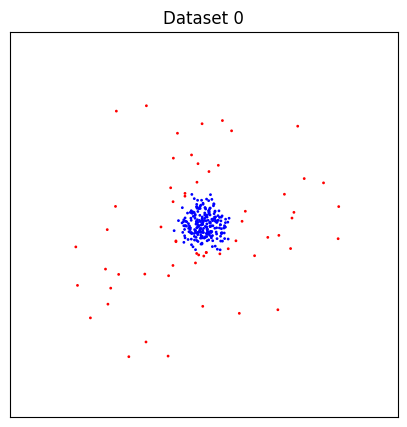

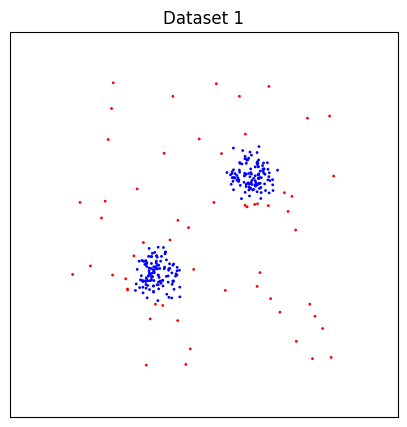

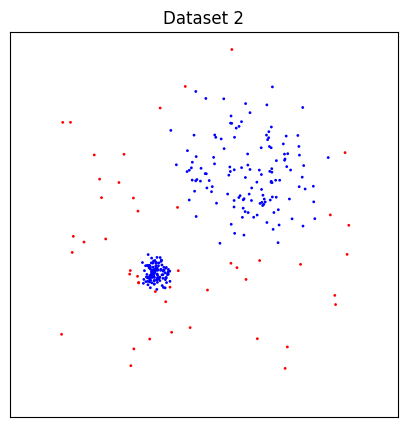

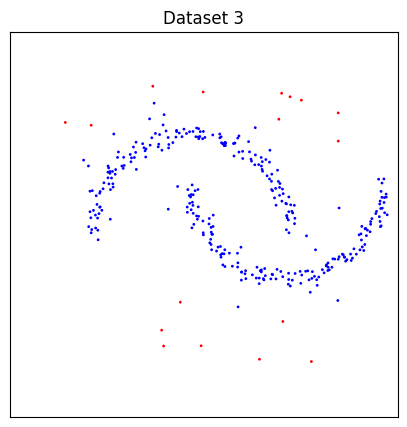

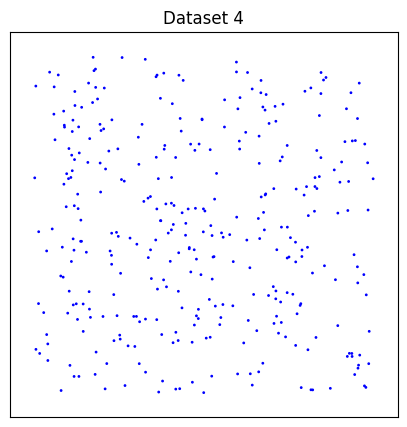

In [6]:
from sklearn.neighbors import LocalOutlierFactor

N_VIZINHOS = 30

CORES = np.array(["red", "blue"])

for n, dados in enumerate(lista_dados):
    modelo_lof = LocalOutlierFactor(n_neighbors=N_VIZINHOS)

    previsao = modelo_lof.fit_predict(dados)

    fig, eixo = plt.subplots(figsize=(5, 5))

    eixo.scatter(
        dados[:, 0],
        dados[:, 1],
        marker=".",
        s=4,
        color=CORES[(previsao + 1) // 2],
    )

    eixo.set_xlim(-8, 8)
    eixo.set_ylim(-8, 8)
    eixo.set_xticks(())
    eixo.set_yticks(())
    eixo.set_title(f"Dataset {n}")

    plt.show();

### Controlando a quantidade de valores anômalos



Podemos instanciar um modelo LOF com um valor numérico para o atributo `contamination` (escolha um valor no intervalo $[0, 0.5[$) Este atributo controla a fração de valores anômalos que serão identificados (com relação ao total de dados que temos). É um valor difícil de sabermos de antemão, porém em certas situações podemos (ou precisamos) controlar a quantidade de valores anômalos.

Vamos ver um exemplo baseado no código apresentado acima.



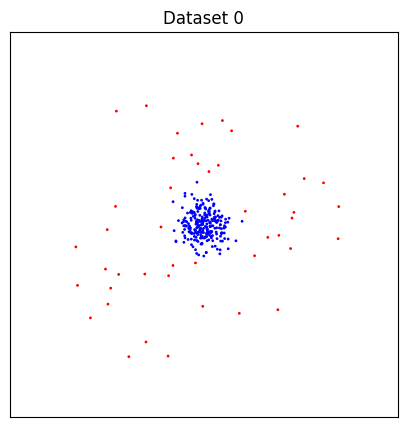

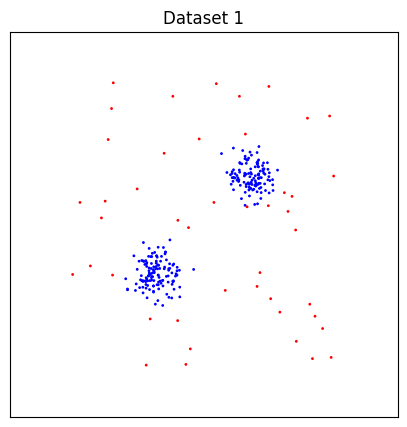

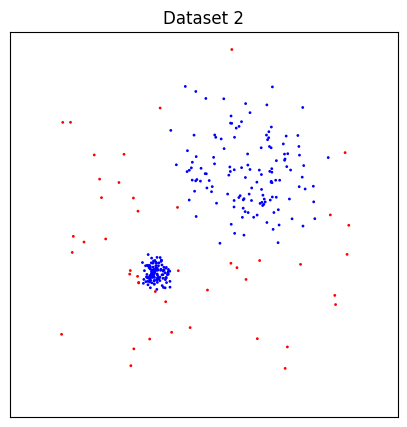

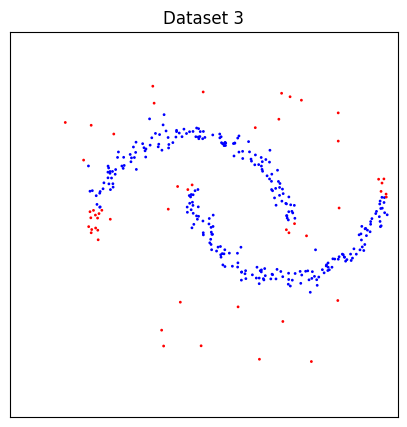

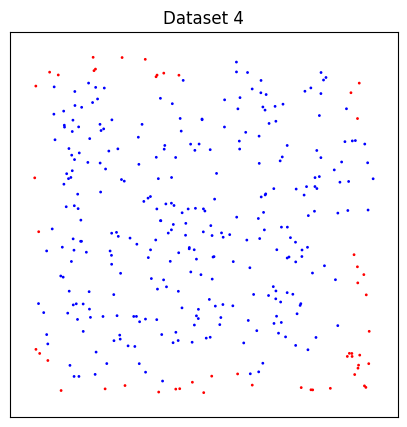

In [7]:
N_VIZINHOS = 30
FRACAO_ANOMALOS = 0.15

CORES = np.array(["red", "blue"])

for n, dados in enumerate(lista_dados):
    modelo_lof = LocalOutlierFactor(
        n_neighbors=N_VIZINHOS,
        contamination=FRACAO_ANOMALOS,
    )

    previsao = modelo_lof.fit_predict(dados)

    fig, eixo = plt.subplots(figsize=(5, 5))

    eixo.scatter(
        dados[:, 0],
        dados[:, 1],
        marker=".",
        s=4,
        color=CORES[(previsao + 1) // 2],
    )

    eixo.set_xlim(-8, 8)
    eixo.set_ylim(-8, 8)
    eixo.set_xticks(())
    eixo.set_yticks(())
    eixo.set_title(f"Dataset {n}")

    plt.show()

### Vizualizando os valores de LOF



Podemos visualizar o LOF de cada exemplo usando círculos! O código abaixo [2,6] é o mesmo do anterior, porém com a parte que plota os os círculos de tamanho proporcional ao LOF. Veja que quanto maior o LOF maior a chance do exemplo ser considerado um outlier.



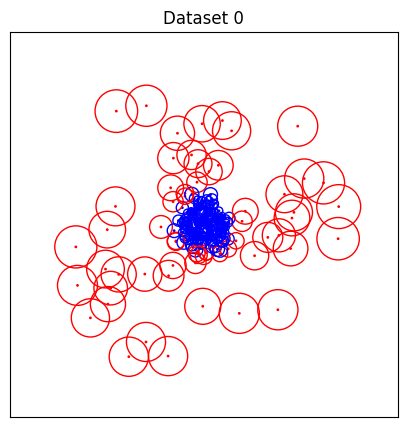

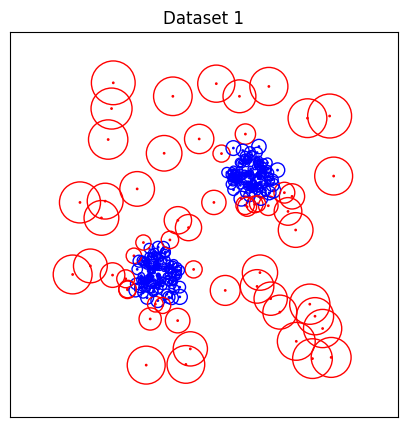

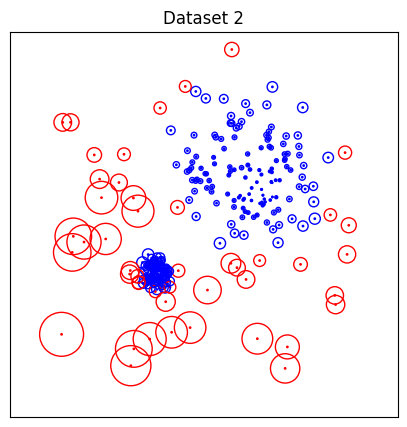

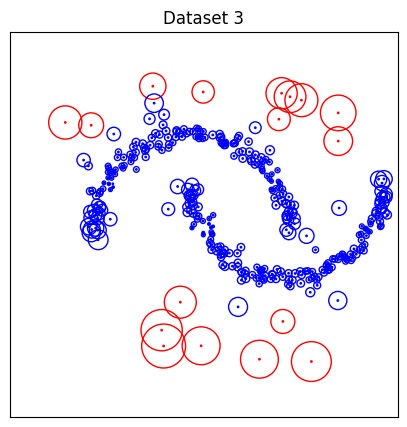

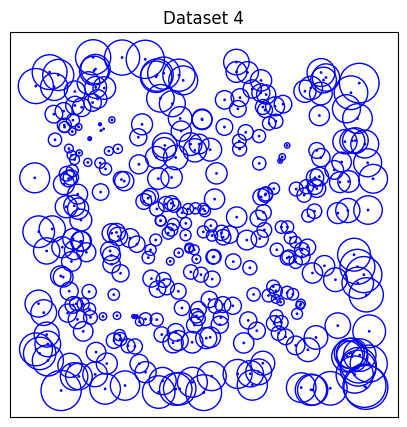

In [8]:
N_VIZINHOS = 30

CORES = np.array(["red", "blue"])

for n, dados in enumerate(lista_dados):
    modelo_lof = LocalOutlierFactor(n_neighbors=N_VIZINHOS)

    previsao = modelo_lof.fit_predict(dados)

    fig, eixo = plt.subplots(figsize=(5, 5))

    eixo.scatter(
        dados[:, 0],
        dados[:, 1],
        marker=".",
        s=4,
        color=CORES[(previsao + 1) // 2],
    )

    # plota os círculos!
    X_lof = modelo_lof.negative_outlier_factor_
    raios = (X_lof.max() - X_lof) / (X_lof.max() - X_lof.min())
    eixo.scatter(
        dados[:, 0],
        dados[:, 1],
        s=1000 * raios,
        edgecolors=CORES[(previsao + 1) // 2],
        facecolors="none",
    )

    eixo.set_xlim(-8, 8)
    eixo.set_ylim(-8, 8)
    eixo.set_xticks(())
    eixo.set_yticks(())
    eixo.set_title(f"Dataset {n}")

    plt.show();

### Alguns pontos a serem considerados



Uma estratégia para encontrar o valor de $k$ é por validação cruzada. Desta forma, este valor deve ser considerado como um hiperparâmetro do seu pipeline que será encontrado durante o processo de otimização de hiperparâmetros. Em geral, os textos sobre o assunto sugerem um palpite inicial entre 20 e 30.

Se um exemplo tem um valor de LOF igual a 1 ou menor que 1, então ele claramente ele não é um valor anômalo. No entanto, não é trivial determinar o limiar do valor de LOF maior que 1 para separar valores anômalos de não-anômalos.



## Algoritmo Floresta de Isolação (IF)



### O algoritmo



O algoritmo de Floresta de Isolação (*Isolation Forest*, IF) é um algoritmo de detecção de valores anômalos que utiliza um conjunto de árvores de isolação para realizar a sua detecção.

A ideia por trás deste algoritmo é que <u>valores anômalos são mais fáceis de serem isolados do que valores que não são anômalos</u>.

Antes de pensar em uma *floresta* vamos pensar em apenas uma árvore de isolação. O objetivo de uma árvore de isolação é isolar todos os pontos de um conjunto de dados. **Isolar os pontos significa que cada vértice folha da árvore contém apenas um exemplo do conjunto de dados <u>ou</u> contém apenas exemplos iguais <u>ou</u> contém zero exemplos.** Os passos para induzir uma árvore de isolação são:

1.  Determine quais são os dados onde quer identificar valores anômalos;

2.  Inicie a árvore criando o vértice raiz. Todos os dados chegam até o vértice raiz;

3.  Observe todos os vértices folha da árvore (isto é, um vértices sem condicional). Se todos estes vértices são isolantes (isto é, contém apenas um exemplo ou contém apenas exemplos iguais ou contém zero exemplos), então encerre o algoritmo. Do contrário, escolha um vértice folha que não seja isolante;

4.  O condicional do vértice escolhido no passo 3 será construído da seguinte maneira: considere todos os dados que chegam até o vértice escolhido e selecione aleatoriamente um atributo destes dados que tenha variância diferente de zero. Selecione um valor numérico aleatório de uma distribuição uniforme limitada pelo intervalo de valores do atributo selecionado. Caso o atributo $B$ tenha sido selecionado e o valor numérico $k$ tenha sido sorteado, o condicional do vértice escolhido será $B > k$;

5.  Retorne ao passo 3.

Para gerar uma floresta de isolação, basta executar o algoritmo acima $N$ vezes, onde $N$ é o número de árvores de isolação da floresta.



### Visualizando uma árvore de isolação



Na imagem abaixo [8] nós temos um conjunto de dados sintético com dois atributos. Veja que conseguimos isolar o exemplo $x_j$ usando 4 cortes no conjunto de dados. Cada um desses cortes representa um condicional que foi visitado em uma árvore de isolação (cada condicional corta o espaço amostral em duas regiões de forma perpendicular a uma das coordenadas).

![img](https://upload.wikimedia.org/wikipedia/commons/f/ff/Isolating_an_Anomalous_Point.png)

Já na imagem abaixo [8] nós temos que para isolar o exemplo $x_i$ nós precisamos de 13 cortes no conjunto de dados (isto é, precisamos visitar 13 condicionais da nossa árvore de isolação).

![img](https://upload.wikimedia.org/wikipedia/commons/c/ce/Isolating_a_Non-Anomalous_Point.png)

Qual desses dois exemplos ($x_j$ ou $x_i$) você acha que tem maior probabilidade de ser um valor anômalo? <code style=
"background:black;color:black">É o $x_j$, pois este é o mais fácil de ser isolado!</code>



### Identificando valores anômalos com uma Floresta de Isolação



Suponha que você já tem uma floresta de isolação. Como fazer para identificar se um exemplo é anômalo ou não? O texto abaixo foi escrito consultando as referências [7] e [8].

O primeiro passo para estimar se um exemplo $x$ é um valor anômalo é computar a profundidade média para isolar $x$ considerando todas as árvores de isolação dentro da floresta. Essa profundidade é computada passando o exemplo $x$ em cada uma das árvores e anotando a profundidade onde $x$ é isolado (isto é, a quantidade de vértices visitados até que $x$ tenha sido isolado). Queremos o valor médio da profundidade considerando todas as árvores da floresta. Estatisticamente, esse valor é a esperança da profundidade $h$ do exemplo $x$, $E[h(x)]$.

Agora precisamos computar a profundidade média $c$ para isolar *qualquer* exemplo pertencente ao nosso conjunto de dados. Para isso podemos calcular a esperança da profundidade de *todos* os exemplos do nosso conjunto de dados e tirar a média destes valores.

Existe uma forma de estimar esse valor $c$ usando a consideração que nossas árvores de isolação são [árvores binárias de busca](https://en.wikipedia.org/wiki/Binary_search_tree). O valor de $c$ para um conjunto árvores induzidas a partir de um conjunto de dados de tamanho $n>2$ pode ser estimado por:

$$
c(n)=2\left[\ln(n-1) + \gamma-\frac{(n-1)}{n}\right],
$$

onde $\gamma=0.5772156649$ é a constante de Euler-Mascheroni.

Finalmente, tento em mãos $E[h(x)]$ e $c(n)$, podemos calcular uma nota $s$ para nosso exemplo $x$ da seguinte maneira:

$$
s(x,n)=2^{-\frac{E[h(x)]}{c(n)}}
$$

Tendo o valor de $s$ nós podemos fazer inferências:

-   Se $s$ é perto de 1, então $x$ é muito provavelmente um valor anômalo;

-   Se $s$ é menor que 0,5, então $x$ muito provavelmente não é um valor anômalo;

-   Se $s$ é menor que 1 e maior que 0,5 é necessário definir um valor de corte até onde aceitamos considerar $x$ um valor anômalo;

-   Se todos os valores $s$ são próximos de 0,5, então é seguro assumir que não existem valores anômalos no conjunto de dados.



### Floresta de Isolação usando `scikit-learn`



O uso da Floresta de Isolação do `scikit-learn` não é diferente do que estamos fazendo desde o início desta disciplina. O código abaixo foi baseado no código da Ref. [2].



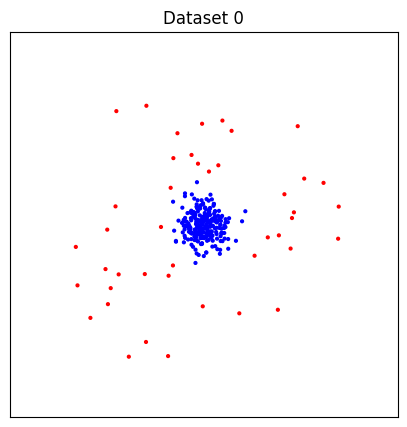

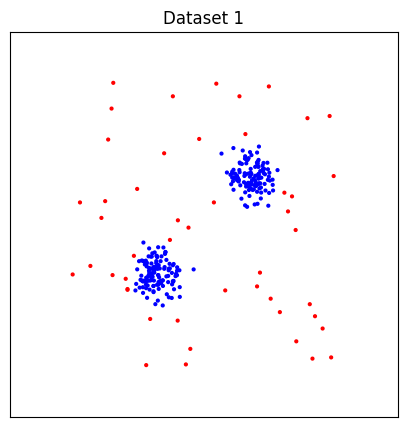

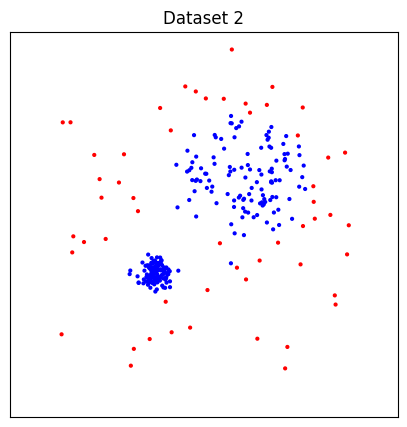

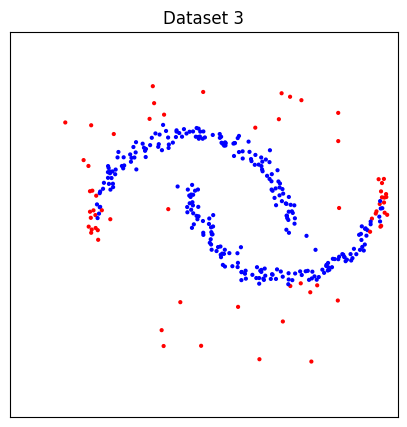

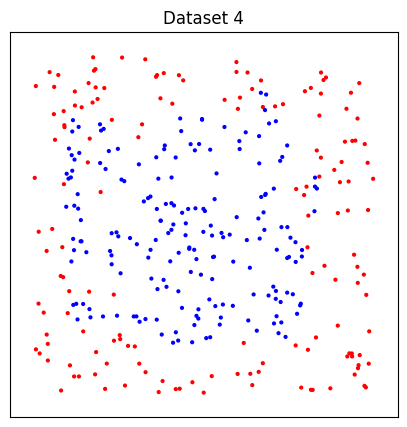

In [9]:
from sklearn.ensemble import IsolationForest

# mude aqui para True para ver a borda de previsão
COM_BORDA_DE_PREVISAO = False

CORES = np.array(["red", "blue"])

for n, dados in enumerate(lista_dados):
    modelo_if = IsolationForest(random_state=SEMENTE_ALEATORIA)

    modelo_if.fit(dados)

    previsao = modelo_if.predict(dados)

    figura, eixo = plt.subplots(figsize=(5, 5))

    eixo.scatter(
        dados[:, 0],
        dados[:, 1],
        s=4,
        color=CORES[(previsao + 1) // 2],
    )

    eixo.set_xlim(-8, 8)
    eixo.set_ylim(-8, 8)
    eixo.set_xticks(())
    eixo.set_yticks(())
    eixo.set_title(f"Dataset {n}")

    # plota a borda entre as regiões de outlier/inlier
    if COM_BORDA_DE_PREVISAO:
        xx, yy = np.meshgrid(
            np.linspace(-8, 8, 150),
            np.linspace(-8, 8, 150),
        )
        Z = modelo_if.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        eixo.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

    plt.show();

O `IsolationForest` também aceita o argumento `contamination` de maneira similar ao que fizemos com o LOF. O processo é similar ao discutido na seção &ldquo;Controlando a quantidade de valores anômalos&rdquo; acima.



### Alguns pontos a serem considerados



Florestas de Isolação são algoritmos rápidos e eficientes, porém podem apresentar alta quantidade de falsos positivos (erro tipo I, exemplos rotulados como anômalos que não deveriam ser rotulados como anômalos).

O valor de corte para a nota $s$ não é trivial de ser obtido. Novamente, é interessante obter este valor através de validação cruzada.



## Avançando nos seus estudos sobre valores anômalos



Vale a pena ler a seção de [detecção outliers e de novidades](https://scikit-learn.org/stable/modules/outlier_detection.html) da documentação do `scikit-learn`.

Os links abaixo são de repositórios de lista<sub>dados</sub> curados para detecção de outliers. Use eles para testar suas habilidades.

-   [https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OPQMVF](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OPQMVF)

-   [https://ir.library.oregonstate.edu/concern/lista_dados/47429f155](https://ir.library.oregonstate.edu/concern/lista_dados/47429f155)

Se você quiser avançar nos seus estudos de detecção de valores anômalos, veja esse [repositório](https://github.com/yzhao062/anomaly-detection-resources) do GitHub com diversos materiais sobre esse tema.



## XKCD relevante



![img](https://imgs.xkcd.com/comics/boyfriend.png)

`Imagem: Boyfriend (XKCD) disponível em https://xkcd.com/539`



## Referências



1.  Detecção de valores anômalos com floresta de isolação [https://medium.com/analytics-vidhya/anomaly-detection-using-isolation-forest-algorithm-8cf36c38d6f7](https://medium.com/analytics-vidhya/anomaly-detection-using-isolation-forest-algorithm-8cf36c38d6f7)

2.  Exemplo de detecção de outliers de `scikit-learn` [https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html)

3.  Vídeo do canal MachineLearningInterview sobre Fator de Outlier Local [https://www.youtube.com/watch?v=Xl7XVPyvO5U](https://www.youtube.com/watch?v=Xl7XVPyvO5U)

4.  Página da Wikipédia sobre Fator de Outlier Local [https://en.wikipedia.org/wiki/Local_outlier_factor](https://en.wikipedia.org/wiki/Local_outlier_factor)

5.  Documentação do LOF do `scikit-learn` [https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)

6.  Visualização do algoritmo de LOF [https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html)

7.  Vídeo do canal MachineLearningInterview sobre Floresta de Isolação [https://www.youtube.com/watch?v=cRzeotaFDwk](https://www.youtube.com/watch?v=cRzeotaFDwk)

8.  Página da Wikipédia sobre Floresta de Isolação [https://en.wikipedia.org/wiki/Isolation_forest](https://en.wikipedia.org/wiki/Isolation_forest)

9.  Documentação da Floresta de Isolação do `scikit-learn` [https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

